## Physically Informed Neural Network

### Example - 1D Poisson (DNN3 $\sigma = \tanh$)

In [1]:
import tensorflow as tf
from tensorflow.keras.constraints import min_max_norm
import logging
tf.get_logger().setLevel(logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
from numsa.TFHessian import *
from random import *
from tqdm.notebook import tqdm


tf.random.set_seed(7)
############| SETTINGS |############
a = -1; b = 1;
N = 50; #Nuerons in the Hidden Layer
N_EvEl = 101; #Spacing of the evaluation function
itmax = 10000;
step = 1e-3;
tol=1e-32
gamma = tf.Variable(1e0,dtype=np.float32)
def f(x):
    return (np.pi**2)*np.sin(np.pi*x);
####################################

#Pnts = np.linspace(a,b,N_EvEl)


Pnts = np.array([0.0])
Pnts = np.append(Pnts,np.random.uniform(a,b,N_EvEl))
Pnts = np.append(Pnts,1.0)
#Pnts = np.random.uniform(a,b,N_EvEl)

Pnts = np.sort(Pnts)

u = tf.keras.Sequential([
    tf.keras.layers.Dense(N,input_dim=1, activation='tanh'),#Hidden Layer
    tf.keras.layers.Dense(N,activation="tanh"),
    tf.keras.layers.Dense(N,activation="tanh"),
    tf.keras.layers.Dense(1,use_bias=False)#10 leyers weights.
])

#We create an evaluation mesh
mesh = tf.Variable([[point] for point in Pnts]);
F = tf.cast(tf.Variable([[-f(point)] for point in Pnts]),dtype=np.float32);
#Defining the lost function
def LSQEnergy(weights):
    with tf.GradientTape() as gtape2:
        with tf.GradientTape() as gtape:
            uh = u(mesh, training=True)
        du_dx = gtape.gradient(uh, [mesh])
    #We use TF Gradient Tape to compute grad uh
    d2u_dx2 = gtape2.gradient(du_dx,[mesh])
    Delta = (d2u_dx2-F)
    Energy = (1/N_EvEl)*tf.reduce_sum(tf.square(Delta));
    #Adding B.C using penalty method idea;
    Energy = Energy + (gamma/N_EvEl)*(tf.square(u(tf.Variable([[a]])))+tf.square(u(tf.Variable([[b]]))))
    return Energy;

In [2]:
print(u(mesh).shape)
print(LSQEnergy(u.trainable_weights))

(103, 1)
tf.Tensor([[50.43338]], shape=(1, 1), dtype=float32)


In [3]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=step)

# Iterate over the batches of a dataset.
for it in tqdm(range(itmax)):
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        Loss = LSQEnergy(u.trainable_weights)
    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(Loss, u.trainable_weights)
    res = sum([tf.norm(grad) for grad in gradients]);
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, u.trainable_weights))
    if res <= tol:
        break;
    if it%(itmax/10) == 0:
        print("[It. {}] Loss function value {} and residual {}.".format(it,Loss,res))
    
print("Loss function value {} and residual {}.".format(Loss,res))    
"""
################| Second Order Minimization Cycle|##############
for epoch in tqdm(range(10)):
    with tf.GradientTape() as tape:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape:
                uh = u(mesh, training=True)
            du_dx = gtape.gradient(uh, [mesh])
            d2u_dx2 = gtape2.gradient(du_dx,[mesh])
            Loss = (1/N_EvEl)*tf.reduce_sum(tf.square(d2u_dx2-F));
            #Adding B.C using penalty method idea;
            Loss = Loss + gamma*(tf.abs(u(mesh)[0][0])+tf.abs(u(mesh)[0][-1]))
    grads = tape.gradient(Loss, u.trainable_weights)
    H = Hessian(LSQEnergy,u.trainable_weights,"KERAS")
    H.SwitchVerbose(True)
    Grad = H.vec(grads).reshape((NWeights,1));
    print("Searching new descent direction ...")
    q = H.pCG(Grad,200,20);
    print("Found new descent direction ...")
    search = [tf.Variable(q[0:50].reshape(1,50),dtype=np.float32),
              tf.Variable(q[50:100].reshape(50,),dtype=np.float32),
              tf.Variable(q[100:100+50**2].reshape(50,50),dtype=np.float32),  
              tf.Variable(q[100+50**2:100+50**2+50].reshape(50,),dtype=np.float32),
              tf.Variable(q[100+50**2+50:100+2*50**2+50].reshape(50,50),dtype=np.float32),
              tf.Variable(q[100+2*50**2+50:100+2*50**2+2*50].reshape(50,),dtype=np.float32),
              tf.Variable(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXwAAAD4CAYAAADvsV2wAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/MnkTPAAAACXBIWXMAAAsTAAALEwEAmpwYAAAxnUlEQVR4nO3deZzWY/fA8c+ZFlLRqrTJkhJJGiVL1seTehTCI0K2bCmVkt0vIlrwKEuIJJJoQWQJiUp7FGWUnoYepX2fmjm/P86dxjTTbN97P+/Xa15zL9+5vtddM+f+3td1rnOJquKccy7xpUS7A8455yLDA75zziUJD/jOOZckPOA751yS8IDvnHNJomS0O5CXKlWqaN26daPdDeeciytz5sz5U1Wr5vZczAb8unXrMnv27Gh3wznn4oqIrMjrOR/Scc65JOEB3znnkoQHfOecSxIe8J1zLkl4wHfOuSQRSMAXkeEislpEfsjjeRGR/4hImogsFJGTgjivc865ggvqCv81oNV+nr8AqBf66gw8H9B5nXPOFVAgefiqOlVE6u7nkHbA62q1mGeISAUROUxVVwVxfueCpgrr18OKFbB6NWzcuPdr2zZISYGSJaFECShTBqpXh8MO2/tVpky0X4Fz+4rUwquawMps99NDj/0t4ItIZ+wTAHXq1IlQ11yy27wZZsyA+fPhhx/sa+lS2LKl6G1WqAC1asFxx0HjxvbVtClUqxZUr50rvJhaaauqw4BhAKmpqb4ziwuLDRvg669h6lT46iuYOxcyM+25GjXg+OPh9NOhbl2oU8eu3g85ZO9X2bKQlWU/k5kJW7fC//4Hq1bB77/b91Wr7NPBjBnw9tt7z33kkXDuudCmjX0vVy4a/wIuWUUq4P8G1M52v1boMeciYv16GD8exoyBzz6D3buhdGlo3hz69IGWLSE1FSpVKlh7JUpAqVJ2u2xZOPRQOOGE3I/dsAG+/x6++w6mTYPRo+Gll+z8LVtC69bwr39BvXpBvFLn8iZBbXEYGsP/QFWPz+W5NkAXoDXQHPiPqjbbX3upqanqtXRccWzYABMmWJD/9FPYtQuOOAIuu8yCbPPmcOCBke9XRgZ88w1MmmRfixfb402bwtVXQ4cO9gbiXFGIyBxVTc31uSACvoi8BZwFVAH+AB4CSgGo6gsiIsAQLJNnG3Cdqu43mnvAd0WhalfSL7xgV9I7dsDhh8Pll9tX06YgEu1e/t2vv9qnj5EjbXipRAm45BLo1g1OPTX2+utiW9gDfjh4wHeFkZkJ48bBgAEW8MuVg44doVMnaNYsfoLmokXw6qvwyiv2CaVpUwv8l18OBxwQ7d65eLC/gO8rbV1cy8iwq/ljjrGhmrVrYcgQmzx9/nkbtomXYA+W1TNwIKSnW/+3bYNrrrFPKU8+aRPEzhWVB3wXl3bvhtdeg/r14dZboWpVGDsWliyB22+H8uWj3cPiKVsWbrnFrvgnT7a0zrvvtjmIAQM88Lui8YDv4ooqvPOOpU5edx1UrgwffQTTp0P79jb+nUhE4PzzLeh/+y00aQK9e1tGz2uvWXqocwXlAd/Fje+/hzPPtPHsEiXg3Xdh1ixo1Sq+hm2KqkULC/zTptn6gOuug5NPtvUEzhWEB3wX8zZtgh497Op28WIYNgwWLrRMlmQI9Dmddppd7Y8aBWvW2Jtg+/aW7ePc/njAdzFLFd56Cxo0gKefhhtusDH6m25KvKGbwkpJgSuvhJ9+gr594eOPbcL36af3rhp2LicP+C4m/fKLlR648kqoWdNKFLz4oo3Zu70OOggeeAB+/BHOOgu6d7fc/e+/j3bPXCzygO9iiqqlI55wgi1Cev55C/bN9rsu29WpAx98AG++CcuWwUkn2RtBRka0e+ZiiQd8FzPS020C9rbbbJz6hx8sNTHZh28KSsTKMvz4o31/9FGb6P3pp2j3zMUKD/guJrz7LjRqZBkozz1n2Si1akW7V/GpShV4/XV47z2r2HnSSfZJKUYX1bsI8oDvoiojw0oHXHqp5ZYvWGALqZIx+yZoF19sY/ktW9qnpvbtbQMXl7w84Luo+fVXqzv/n/9Y0J82DY4+Otq9SiyHHWYL0wYNgokTrQT0woXR7pWLFg/4LiomTLC8+qVLbejh6aetPrwLnoitY/jiCyvJcMopVpnTJR8P+C6isrLg3nvhoovgqKMsE+fii6Pdq+Rwxhn27928uRVku/VW2Lkz2r1ykeQB30XMpk3Qrh08/rgtnvrmG9vyz0VO9eq2Gczdd1uV0TPOsMqiLjnE1J62LnGlpUHbtjaEM3RoDE3M7tq1d6/CsWNtc9pNm6wusaot8736ant+/HgoWdJ2KK9a1WoWR2PLrGIqWRL697ehnauvtno8779v2TwusfkGKC7svv3Wgj1Ypcuzz45SR+bMsd3Lv/sOfv4Zli+3sptffmnPN2hgtRvAaheI2Gaz48fbY1Wrwp9/7m1PBG680Yr7gO1X2KiR5ZPGxLtZ/hYuhAsvtJo8I0daJo+Lb/vbAMWv8F1YjRtn5RFq1bJskYhl4axda7uVp6XBfffZY/fdZwn+tWtDw4a2nVSTJnt/5vPPbVup8uVz315q+nRYt862ovrjD1vS2qCBPbduHbRpY7erV7elwc2bWwStXz+sL7U4TjjB3v8uushSYwcNsglel5g84LuwefZZS7ds3txSAqtWDfMJ09NtBde4cXYln5VlwbtHDyhTxlKBDj4YatTI/edr1tx/+/t7tzr4YIuc2b8mTrTiP/Xrw+rV9lGnVauYGwaqVs0yeDp2hJ49bUz/ySftQ45LMKoak19NmzZVF58yM1V79lQF1YsuUt26NYwnW79+7wmGDLGTHn+86v33q86YobprVxhPno8//lDdsMFuv/KK9a1cOdXrr1edPl01Kyt6fcvF7t2qt99u3bzyStWdO6PdI1cUwGzNI65GPbDn9eUBPz7t3Kl6xRX2m9WliwWRwGVlqX71lZ3ogANUX3rJHl+3TvXnn8NwwgBkZKh+8onqddepli1r/0CNGqlu2RLtnv1NVpbqY49Z9847T3XTpmj3yBXW/gK+f2hzgdm508aBR4+GJ56wFbSBFj7LzIThw+HEE23Xj8mTLb+zRQt7vmLF2F2qW6oU/OMf1v9Vq6zW8+mn2+a1YKlLCxZEt4/YXPM998Crr9owz1ln2YSuSwyepeMCsX277UD18cdW/OzWWwNsXNUikapNhu7cCV272mzwQQcFeKIo2b7dZrXXrbMx/rvvtje0KGf6fPSRzTnXrWu5+/lNcbjYsL8sHb/Cd8W2daul9k2eDC+/HGCw377dPiYce6ylQ4pYFFqwwNIhEyHYg00op6VBv36WOnr22XDOOVGva3zBBfYGnp5uC7R8C8X4F0jAF5FWIrJERNJEpE8uz9cRkS9EZJ6ILBSR1kGc10Xf5s3QurV9/B8xwrYhLLbMTHvnOPJIS/M59FC7+gWr/RsnOe6FUrGi1ZxYsQKeeca2/CpTxp6L4p6FLVtatuqGDTa840E/zuU1uF/QL6AE8AtwJFAaWAA0zHHMMODW0O2GwK/5teuTtrFvwwbVFi1US5RQHT06oEa3bFFt3NhmDU89VfXLLwNqOM5kzy664ALVG25Q/e23qHVnzhzVihVV69RRXbYsat1wBUCYJ22bAWmqukxVM4DRQLuc7yvAwaHbhwBevSPOrV9vc5CzZ8OYMfDvfxezwc2b7XvZsnDeedbotGk2lp2MSoaWyOzaZXn8I0fa98GD7bEIO+kku9LfssX+S5Yti3gXXACCCPg1gZXZ7qeHHsvuYaCjiKQDk4A7cmtIRDqLyGwRmb3GUwNi1p9/2hDzggVW2viSS4rR2O7dMHCgrX7dU6h94EC47LLEHLoprFKl4KmnYNEiG1/p2dNWBy9eHPGuNGkCU6ZYmaEzz7RRJxdfIjVp2wF4TVVrAa2BkSKyz7lVdZiqpqpqatWwL8t0RbF+vV2A//STLST917+K0dicOZZ106uXRZBKlQLrZ8I5+mjbpXzCBBvvj1LKTOPGFvS3b4dzz4WVK/P/GRc7ggj4vwG1s92vFXosuxuAMQCqOh04EKgSwLldBG3ZYhO0P/5o9cT++c9iNHbvvRbsV62yKpXjx/smtvkRsSp0X38Nhxxi+0O2a2cz5hF0wgnwySd73/xXr47o6V0xBBHwZwH1ROQIESkNXAFMzHHMf4FzAUTkWCzg+5hNHNmxw2LLrFm2sKpYwR5sRdaNN9q7R/v2PnxTFOnpNrRzzjm2ae2eeZAIOOkkKw6ang7nn2/B38WBvGZzC/OFDdMsxbJ17gs91hdoq3szc77BMnjmA+fn16Zn6cSOjAzVf/3LEmdGjixiI7t2qT76qOrkyXY/xurIxK2tW1W7d1cVUa1XT3Xu3Iie/pNPVEuXVm3e3MswxAq8lo4rqt2799bGee65IjaSnq56xhnWSNeugfbPhXz5pWqNGqqpqRF/M33vPUvNPfts1W3bInpql4v9BXxfaevypArdu9sQTv/+RVxB+/nnlt4xd66lFj7zTOD9dNik94IF9p8lYsM7a9dG5NQXXwyvvWZTCVdcYYlXLjZ5wHd5GjjQatr36GHlXQpt5kxL1q9SxQb/O3YMvI8umypVbGd4gDvusCJzs2ZF5NQdO1oVjIkTrcxRjJboSnoe8F2uRo2C3r1tQdWAAYX84aws+96smV3Rf/ed1cNxkXPHHTYxfsYZVqEzQqfs1Quef96qpbrY4wHf7eOzz+C666x2yogRhdz5aOFCG8JZtsyGFu64A8qVC1dXXV6aNrVl0GecYQWObrvN0jjDrH9/6NDBSiy/8UbYT+cKyQO++5v5823lbP36tlNgblu75mnSJDjtNFuKG8EUQZeHKlWsumjv3laq4recy2OCl5JitfTPOguuv96mcFzs8IDv/rJihS2sOuQQixMVKhTih4cOtRrJ9erZEE7jxuHqpiuMkiVtfGXJEjjiCBtcD3PZkgMOsIuF+vVtQjcG9nVxIR7wHWALZ1q1siXzH39cyEWvr78OXbpAmzYwdarvlBGLKle27/3725vxvHlhPV2FCvaB7+CD7SLCSzDEBg/4jl274PLLrRjW+PFw3HGFbOCyy6yK47hxPl4f69q2tav+M86wj3FhVLu2nWLLFttMZdOmsJ7OFYAHfEf37jZR++KLhahGnJ4OV10FGzfaRh3duwe8ga0Li+OOgxkz4JhjbAhu2LCwnq5RI6uo+tNPtiNlFPdycXjAT3pDh9pXr16WmVMg8+dD8+aWdB2FMr2umGrUgK++sjUSt99u2yuG0bnnWo7+hx9azTwXPSWj3QEXPZ9+ajsIXnghPP54AX/o66+tJvIhh8A331jpRBd/ypeH99+3q/2jjw776W67DX74AZ580j5kXHNN2E/pcuFX+Enqp59s6L1hQ1tkVaDRmClTrDRijRrw7bce7ONdyZJw+ul2+913rS5CGHP1n3nG9me/6SZ7n3GR5wE/Ca1daxfpBxxgF3nlyxfwB+vVs1SeqVO9dn2i+e03ePtty6Pcvj0spyhVCt55x351LrrIM3eiwQN+ktm92zJyVq60pJrDDy/AD332mc221a5tP+S7kSWerl1tAvejjyy9dsuWsJymcmW7yNi2zYL+tm1hOY3Lgwf8JHP33TYy8+KLcOqpBfiBoUNtcu/FF8PeNxdlN91k9RCmTrWgv2NHWE7TsCG89ZYtBejUyQutRZJP2iaRN9+0dPkuXewPLV9Dh9rB7drZ7lQu8V15pU3ozJtXyLoahdOmjS0A7t3bpoLuvz9sp3LZiMbo22tqaqrOnj072t1IGPPn2xV9aqrVNylVKp8fyB7sx4yB0qUj0U0Xa375xSbpy5QJvGlVuPpquxCZNMmmh1zxicgcVU3N9TkP+Ilv7VoL9Lt3WwHFatXy+YHff7dUvfPP92CfzLZssQVajRrBhAlw4IGBn2LbNmjRwuaU5syxcj+uePYX8H0MP8FlZlq52lWrbMVjvsEe7Ipu2jQP9smuXDno188WbFx8MezcGfgpDjrIfi9VrUprmBKEXIgH/AT3f/9nf69DhsDJJ+dz8HPPwcsv2+2TTvJg72z59bBhVlHvqqvCUhvhqKNsrnj+fNtGM0YHHRKCB/wE9tFH8Mgj9jeb75zr8OG2zP6DD/wvzv3djTfabP+778KgQWE5RZs28NBDtuHOCy+E5RQOH8NPWCtW2EV67dowfXo+c27vvWfLbs87z+rjhDE7w8WxkSNt3KVs2bA0n5VlZT4+/dRGFJs1C8tpEp6P4SeZnTvh0kttknbs2HyC/Wef2SD/KadY4Pdg7/Jy9dUW7DdtskT6gKWk2NBOjRq2l/L69YGfIul5wE9A3btbNs6IEQWoizV/PjRoYEM5Ybpycwlm8GDL198z3xOgihWtwsNvv9lQZIwOQMStQAK+iLQSkSUikiYiffI45nIRWSwii0TkzSDO6/b19tvw/PNW7viii/Zz4J7Jt7vugpkz7S/NuYK47z5Lmr/llrBsotK8uVXVnDDBCq654BQ74ItICWAocAHQEOggIg1zHFMPuAc4TVWPA+4s7nndvpYvh86dLa+5X7/9HPjLL5ZbvadkYRjyq10CK1XKUnZPOMHmfubODfwU3brZBUuvXnY94oIRxBV+MyBNVZepagYwGmiX45ibgKGquh5AVVcHcF6Xza5d9ikbbOVinitp//jDFlStXm0bjjpXFOXL2zBg5cpWgyfgsRcRSxyrVcvG89etC7T5pBVEwK8JZC90mh56LLtjgGNE5BsRmSEiuS6iFpHOIjJbRGavWbMmgK4lj4cftgv2YcOgbt08Dtqyxeoir1pl2w81bJjHgc4VQI0alp8/bpxF6IBVrGgfJH7/3cfzgxKpSduSQD3gLKAD8JKIVMh5kKoOU9VUVU2t6iV4C2zKFNux6oYb7GooV3t2Kp871/6KmjePaB9dgjr2WKhTx3Iqn3su8NW4J58MAwdatvDgwYE2nZSCCPi/AbWz3a8Veiy7dGCiqu5S1eXAUuwNwBXTn39Cx45Qv34+E1yZmZaF8/zzdpXvXJCmTbOFezfeGPil+B13WPp/nz6WfeaKLoiAPwuoJyJHiEhp4ApgYo5jxmNX94hIFWyIZ1kA505qqvZRd+1aGD16P1mVGRk2MTtmjM3qOhe0li3h0Uctkf7JJwNtWsQyQA87zJaMhGlvlqRQ7ICvqruBLsBk4EdgjKouEpG+ItI2dNhkYK2ILAa+AHqp6trinjvZDRli82YDB0LjxnkcNGoUNG1q4/ZhGGd17i/33mtjivfcY9taBahiRftVXrbMrvhd0XhphTi1YIEtPT//fBvfzDWWT5sG555rhfAnT/ZiaC78tm2zq/0VKyxPuFy5QJt/8EGrD/XWW7bnutuX18NPMFu3Wn37jRth4UKoUiWXg375xSZmK1e2YjqVKkW8ny5JpadbgfsWLQJvevduez9ZtMguevLMSEtiXksnwXTrBkuW2HBprsF+/XorP6hq6Zce7F0k1aq1N9hPnmwZYgEpWdKGdsDWnezeHVjTScEDfpx5+2145RUbJj3nnDwO2r4dKlSA8eMLUEzHuTCZP99KMNx5Z6DNHnGElVCePh369g206YTnQzpxZPlyOPFEWy81dWoeq2lVbUB/z3fnoql3bxgwwHL0b7010KY7dbKKzV98YcM8zviQTgIoUOmE4cOtAMnWrR7sXWx4/HEbXuzaFb79NtCmn33WrvavucYqNrv8ecCPE3377i2dkOtGzzNn2hXUtm1e097FjhIlbLLp8MOt0NrmzYE1Xb68XeGvXGnzWi5/HvDjwPTp8Nhj9hE219IJ//ufLUWsUcNWYJUsGekuOpe3ChVsJ57HH7coHaAWLWw+67XXrKSP2z8fw49xW7dCkya2WHbhwlwKXGZk2Ozt3Ln2zpDnCiznYsQff0C1aoE1l5FhG7atXAnffw/VqwfWdFzyMfw41qcP/PwzvPpqHtWMly+HtDQbv/dg72LdN9/YmOTEnNVXiq50aRs12rw5LJWaE4oH/Bj2+edWPqFbNzj77DwOql8fli71ZYcuPjRtahU2r7nGFgcGpGFD6N/fSo288kpgzSYcD/gxauNGK4xWv74Nfe5j5kxbZ56V5RuZuPhx4IE2np+SAu3b25qRgHTtaqObd94Z6HtJQvGAH6O6dbONH15/HcqUyfHknknaN97wfDQXf444wn53FyyALl0CazYlxYY+S5SAa6/du22z28sDfgyaMAFGjLDsg2bNcjyZkQGXXmrlE8aNswwI5+JN69bwwAP2+5uVFVizderA0KE2VTBgQGDNJgzP0okxa9bA8cdDzZqWd79Pgctbb7V15V4u0MW7MK0GV7XN3SZMgFmzki+XwbN04oQq3HILbNhgQzn7BPulS21GqlcvD/Yu/u0J9jNm2C5sAY3ni9g1UaVKNg8WYO22uOcBP4aMGgXvvWf1vo8/PpcDjjnG9njLdRbXuTi1aZNVdQ2wyFrlyrab57x58MQTgTUb9zzgx4j0dJu/Ou006Nkzx5Nr1tjnU4ATTrBZKecSxfnnw913W92QMWMCa/bii+2DcN++tiDLecCPCapwww320fO113LE86ws26X83/+2tB3nEtEjj1idhJtusn0MA/LsszYv3KmTD+2AB/yY8NJL8MkntjftPuXr+/WzJ//zH6uV41wiKlXKysCmpFiUDkiVKlaZee5cz9oBz9KJupUr4bjjLP3y009zJC18/jn84x9w1VU2i+slj12i+/FHm6sKeNhyT9bO3Ln295bIPEsnRqnCzTfbApGXXsoRzzdssAL4DRrY7JMHe5cMjj3Wgv2qVTbjGpAhQ2xB+nXXJfe2iB7wo2jkSPjoI6sBsk+N+woV4MknbRl6uXLR6J5z0aFqK8kvushqjATg0ENtQdasWTBoUCBNxiUf0omSVaus4NNxx9l2hSnZ33rXr4eKFaPWN+eibuZMS1m74gorwxAAVduD5f337cNDw4aBNBtzfEgnxqjCbbfBjh1W1fhvwf7rr219+JQpUeufc1HXvLkVBxw1ylaVB0DErvLLl0/eoZ1AAr6ItBKRJSKSJiJ99nNcexFREcn13SdZvPMOjB8P//d/Nj/1l3XrbIK2enU4+eRodc+52HDvvXDqqVZOZMWKQJqsVs3G87/7Dp56KpAm40qxA76IlACGAhcADYEOIrLPhyURKQ90A2YW95zxbM0aW2CVmgo9emR7QtVykFetsiuagLeCcy7ulCxpE10XXxxoCfB//9umBx54AH76KbBm40IQV/jNgDRVXaaqGcBooF0uxz0CPAHsCOCccatbN0vAGT48x9azw4ZZXYXHHrN3A+ccHHmk1TyuWDGwraxELPHtoIPg+uuTq4xyEAG/JrAy2/300GN/EZGTgNqq+uH+GhKRziIyW0Rmr1mzJoCuxZYJE+zi/f77oVGjHE/++qstMd+nroJzjmXL4PTTrYZ+AKpXt/Vd06cHus4r5hU7S0dELgVaqeqNoftXA81VtUvofgowBeikqr+KyJfAXaq63xScRMvS2bDBsgKqVrXUsH0qYYKt/S5VKtJdcy72rV1rKW3Vqu3nD6hwVK1I51dfwaJFcPjhAfQzBoQ7S+c3oHa2+7VCj+1RHjge+FJEfgVOASYm28Rtz56werUN5fztd/XRR+0yAzzYO5eXypVtdeLChVYNLQB7hnbA5oVjNEM9UEEE/FlAPRE5QkRKA1cAf21Jr6obVbWKqtZV1brADKBtflf4ieSLLyzQ33WX7eH8lwkTbObo3Xej1jfn4saFF1oVtP79Lc0mAHXqWLmqjz6C0aMDaTKmBbLwSkRaA08DJYDhqtpPRPoCs1V1Yo5jvySJhnS2b7eKxqpWovWv/WnT020rnrp14dtv4YADotlN5+LDxo02Ada0qW3xGYDMTMv+XL7cSvlUrhxIs1GzvyGdkrk9WFiqOgmYlOOxB/M49qwgzhkvHn0U0tKsMNpfwT4z00oe79xps7ge7J0rmEMOgcmTc6lFUnQlSthoUdOm9in81VcDazrm+ErbMFq40MrhXHstnHdetidGjrSZoqFDc6y8cs7l69hj4cADYfNmuyQPwAknQO/eth/FZ58F0mRM8lo6YbLfj4mZmTBxoq3+8CqYzhXNP/5h6ZoLFgRSYHDHDgv8mZk2/HrQQQH0MQq8lk4UPPeczSs9/XS2YL9hg62kLVHCVg96sHeu6B54wK6o7r47kOYOPNDWPy5bZmVPEpEH/DBYudLKgPzzn9ChQ+hBVejc2VbRbt0a1f45lxBatoSuXe3qaurUQJo86yzbbnTQoEDL8ccMD/gB21MJMysLXngh20X8K69Y1bSuXaFs2aj20bmE0a+fTeDeeKOlxAVgwADbGvGmmxKvoqYH/ICNHQsffGB7MtetG3owLQ3uvBPOOQd69Ypi75xLMGXLWopNzZo2ZBqAihVtC+k5c+x7IvFJ2wCtX28JBLVqwYwZoeJou3dbDZAlS2wmqFataHfTucSjGuicmCq0bWvbUvzwQ6BZoGHnk7YR0rs3/PmnXXD8VQlz+3aoXdvGdzzYOxceIvD779C9O2RkBNLcc8/Z5kS33JI4ZRc84Adk6lR4+WWrcd+kSbYnypeHMWOsCLdzLnzmzLG0uP79A2mudm14/HH45BPbeCsR+JBOADIy4MQT7WJ+0aJQ/u7WrTaRtM+2Vs65sLnySptImzfPqmsWU2amba27bJmNysbDVtM+pBNmgwbZ4qqhQ7Mt1ujZE95+2z5mOuci45lnrPzCDTcEsrNJiRLw4ou2+2ifPDdvjR8e8Itp+XLLyLnkEmjdOvTg++/bb8ldd1lir3MuMqpWtR1NZs60QfgANG5sSXbDhlmdw3jmQzrFsGcDhalT7Qq/Vi2s6H2jRnDYYfZL54XRnIssVcun7NgxsNKXW7bYBkYVKthUQSxvXeFDOmEybhxMmmT7MfyVgNOvn+UDv/GGB3vnokHENo+uXNmGdQK4qC1Xzj44fP+9jRrFK7/CL6LNmy3nvkoVmD07Wxrmtm2WhH/OOVHtn3NJ748/oE0bS5278spAmmzXzqppLl4cu1si+hV+GDz8sM3HvvBCKNivXm2ZOQcd5MHeuVhQpYr9cd55p826BmDPhudduwbSXMR5wC+C+fPtY13nznDKKdhHxquusvytADIDnHMByJ5iE1BFzTp1LNN64kTboTTeeMAvpKwsW3lXqZItygBsJ+TPPrMnSpSIav+cc9k0bmxDOi+/DF9/HUiT3bpZXsYdd9hkbjzxgF9IL71kyTeDBoUWYaSlWUG0f/4Tbr452t1zzuX00EM24D5oUCDNlSplHxxWrrSh3Xjik7aFsHo11K9vq2qnTAHJyrSa3IsXW4WlmjWj3UXnXG6WLLHytQFmzt18s1U9nzPHPkjECp+0Dchdd9m87PPPhwrzrV9vN4YM8WDvXCyrX9+C/ZYtga1+79/fhnZvvtmGeuOBB/wC+uIL23u8d29o0CD0YJUqtuoqoJQv51wYZWXZRtNXXx1Ibn7FijB4sA3xDhsWQP8iwAN+AezcCbfeCkceCffdh1VL69XL8nxTUnxvWufiQUqKbUc3ZYotjAzAVVdZFnafPjbkG+sCCfgi0kpElohImojsU2JIRHqIyGIRWSgin4tIjC5ZyN3AgTYEOHQolCmDFc8ZONB2KXfOxY/OnaFFC8vcWbu22M3tqZu/bZt9+o91xQ74IlICGApcADQEOohIwxyHzQNSVfUEYCzwZHHPGym//AKPPgqXXQatWmFB/vHHoVMnuPDCaHfPOVcYKSmWYrNhQ2Dbjdavb/N7I0bAtGmBNBk2QVzhNwPSVHWZqmYAo4F22Q9Q1S9UdVvo7gwgLrZ+UoUuXWyx3lNPYQXvr7kGatSwjRacc/GnUSMrX75iRSC7Y4EN9dapYyNGsbzxeRABvyawMtv99NBjebkB+Ci3J0Sks4jMFpHZa9asCaBrxTN2LHz8sV3h16yJ3ViyBF591WpuO+fi0yOP2GLJ0qUDaa5sWbsG/P57S9qLVRGdtBWRjkAqMCC351V1mKqmqmpq1apVI9m1fWzaZCU4mjSB228PPXjnnTB8OJx7bhR75pwrtlKlbAA+PR0+yvX6s9AuugguuAAefDB29z0KIuD/BtTOdr9W6LG/EZHzgPuAtqq6M4DzhtVDD8GqVaHiaBnb7HNa1apw3XXR7ppzLihdu8IVV9gfezGJWHG1jAwb049FQQT8WUA9ETlCREoDVwATsx8gIk2AF7FgH/PJS99/b/9xnTtDs2ZY0YyzzortwTnnXOE98QTs2BFYis1RR1mK5ltvWfZnrCl2wFfV3UAXYDLwIzBGVReJSF8RaRs6bABQDnhHROaLyMQ8mos6VRvCqVDB9jLhgw9sGKdly2xF751zCaFePQv2b7wBX30VSJN3321rdm6/PbA54cB4LZ0c3njDFuINGwY3XbIWjj8eDj3U0jF9ByvnEs+2bXDccTbzOm9eIPsXfvihbX/av39glZkLzGvpFNDGjZaa26yZbXrPbbfZ4ozXX/dg71yiOugg2wO3eXMb3glAmza2O1bfvvDf/wbSZCA84Gfz8MNWLWHoUEjZsM52Onn44dgqheecC96FF1rpy/LlA2vymWdsiLhHj8CaLDYP+CHZJ2pTU7EyePPmxcd6aedcMObMsS2tAnD44XD//fDuuzB5ciBNFpsHfHJM1D6qtsvJnv1pfaLWueTx4Yf2qf7zzwNprmdPOOYYW7Ef0GhRsXjAB0aNst3P+veHyp+8ZZf5I0ZEu1vOuUjr3dtyK2+/3crkFtMBB9gQcVoaDMh1uWlkJX3A37jRFkk0awbXX7DK3opPOcW3K3QuGR14oI3tLlkSKqBVfOedB5dfDo89BsuXB9JkkSV9wH/4YatjPXSIknLbLVYg7bXXfDNy55LVBRdA27ZWOyugGgmDBllI6do1kOaKLKkD/sKF9mZ+882QumQUTJxoq63q149215xz0TR4MNxzjyVvBKBWLbu4/OADCzPRkrQLr1Rt8eyPP8LSpVBp7c9W5m7wYL+6d84FbtcuK8a4ZQssXmw5IeHgC69yMWqUbVbQ/3GlUkW1JdbPPOPB3jm316RJ0L59ILuUlyplE7grVtgeStGQlAH/bxO1JV+HSy6BzZuj3S3nXKzZsAHee8/2wAjAmWdCx47w5JM2shBpSRnwH3ooNFH70GpSunez8glly0a7W865WNOhA5x2mo3nb9gQSJMDBlgyULduNrQcSUkX8BcutKH6mzsrqUM62cDa8OG216VzzmW3p8j9n39aYZwAVK9ui3k//hgmTAikyQJLqij3txW1DUfZTjf9+8PRR0e7a865WNWkCdx0kwX+X34JpMkuXawQb7duVqwzUpIq4L/xRmiitl8mlYb0tQG1v/YvdM65PDz6qK2+P/LIQJorWdImcP/738hO4CZNWubGjZZef/jhMH06pKz70xZZ1a6d/w8759weWVmBDQFfdRWMHQuLFgU30OBpmeydqH3uzqWkaCZUqeLB3jlXOCNHQtOmgVVCGzDA6u1EagI3KQL+XxO1V26m6c2pVsLOOecKq3p12ydj8OBAmqtRw1bgTpoE778fSJP7lfBDOntX1CpLj29PpTmfWvH7unWL30nnXPK5+GL45BMrsFarVrGb27MCd+tWW4Fbpkzx2kvqIZ09E7VPtP6KSl+Ns89QHuydc0U1aBBkZga2WW2pUjYC8euv8MQTgTSZp4S+wt8zUVv3sJ18+3NVUlo0t3dmkYB66ZxLSg88YJk7P/0UWLHFDh1g3Di7yi9OMlDSXuH/taK29wpSjq0PL7/swd45V3x9+sC33wZaWXfgQLvav/POwJrcR8IG/Oylj5t2OAa++85yMp1zrrjKloUWLex2QCunataEBx+0ydsPPwykyX0kZMDfs6K24iGZ9JP7bTbEr+ydc0EbPBiOPdZiTAC6dYMGDWynxXCMtgcS8EWklYgsEZE0EemTy/MHiMjboednikjdIM6bl78mag8dTKVRz8K6deE8nXMuWTVvbstlA9qwtnRpS/UfPz4816jFDvgiUgIYClwANAQ6iEjDHIfdAKxX1aOBp4CwzUVv3Ai9ekHzuv/juiV32zuwL7ByzoXDaafZhrVPPgnp6YE0mZpq23OEQxBX+M2ANFVdpqoZwGigXY5j2gEjQrfHAueKhGeMZccOOO3ELQz9X3tSWv0Trr8+HKdxzjnzxBNWbuGee6Ldk3wFEfBrAiuz3U8PPZbrMaq6G9gIVM7ZkIh0FpHZIjJ7zZo1RepMtWrwrlxG0wMWwUsv+di9cy686taFHj2sKM6qVdHuzX7F1KStqg5T1VRVTa1atWrRG3r2WXjzzUBWwTnnXL7uucc2yD7ssGj3ZL9KBtDGb0D2QfJaocdyOyZdREoChwBrAzh37o4+2mvcO+cip3x5+1KFNWvg0EOj3aNcBXGFPwuoJyJHiEhp4ApgYo5jJgLXhm5fCkzRWF3i65xzRdWjB5x8spVej0HFDvihMfkuwGTgR2CMqi4Skb4i0jZ02CtAZRFJA3oA+6RuOudc3Gvb1tI0n3oq2j3JVULX0nHOuYi75BKr2fXzz1EZ00/aWjrOORdxAwZARgbcf3+0e7IPD/jOOReko46yGgmTJsGmTdHuzd94wHfOuaA9+KBtkHLwwdHuyd94wHfOuaCVL2/Bfvdu29kkRnjAd865cLn0UmjVyvYxjAEe8J1zLlyuv96GdoYNi3ZPAA/4zjkXPhdeCGeeCQ8/bKV8o8wDvnPOhYuIbXr+55/w+OPR7o0HfOecC6umTeHqq2HKFMjMjGpXgiie5pxzbn+GDLF9cEuUiGo3/ArfOefC7eCDLdhv2ADLl0etG36F75xzkaBqWyJWrgxffRWVzZn8Ct855yJBBO64A77+GiZMiEoXPOA751yk3HgjNGgAvXtbgbUI84DvnHORUrKkVdP8+Wd48cWIn94DvnPORVKbNnDOOTBrVsRP7ZO2zjkXSSIwcaKlaUaYX+E751yk7Qn2y5ZBenrETusB3znnomHrVluF26tXxE7pAd8556KhbFno0gVGj4aZMyNySg/4zjkXLb17Q7Vq0LOnLcwKMw/4zjkXLeXLQ9++8M038N57YT+dB3znnIum66+Hxo1h6dKwn8rTMp1zLppKloTvvoPSpcN+qmJd4YtIJRH5VER+Dn2vmMsxJ4rIdBFZJCILReTfxTmnc84lnD3Bfto0WL8+bKcp7pBOH+BzVa0HfB66n9M24BpVPQ5oBTwtIhWKeV7nnEssv/5q2yH26xe2UxQ34LcDRoRujwAuynmAqi5V1Z9Dt38HVgNVi3le55xLLHXrQqdO8OyztiArDIob8Kup6qrQ7f8B1fZ3sIg0A0oDv+TxfGcRmS0is9esWVPMrjnnXJx55BEoVQo++CAszec7aSsinwHVc3nqvux3VFVFJM9EUhE5DBgJXKuqWbkdo6rDgGEAqamp4U9Kdc65WFKjBqSlQfXcQm7x5RvwVfW8vJ4TkT9E5DBVXRUK6KvzOO5g4EPgPlWdUeTeOudcogtTsIfiD+lMBK4N3b4W2GcbFxEpDYwDXlfVscU8n3POuSIqbsDvD/xDRH4GzgvdR0RSReTl0DGXAy2BTiIyP/R1YjHP65xzrpBEI1C/oShSU1N19uzZ0e6Gc87FFRGZo6qpuT3npRWccy5JeMB3zrkk4QHfOeeShAd855xLEh7wnXMuScRslo6IrAFWFPHHqwB/BtideJCMrxmS83Un42uG5HzdRXnNh6tqrvXKYjbgF4eIzM4rLSlRJeNrhuR83cn4miE5X3fQr9mHdJxzLkl4wHfOuSSRqAF/WLQ7EAXJ+JohOV93Mr5mSM7XHehrTsgxfOecc/tK1Ct855xzOXjAd865JBHXAV9EWonIEhFJE5F9NlAXkQNE5O3Q8zNFpG4UuhmoArzmHiKyWEQWisjnInJ4NPoZtPxed7bj2ouIikjcp+8V5DWLyOWh/+9FIvJmpPsYDgX4Ha8jIl+IyLzQ73nraPQzKCIyXERWi8gPeTwvIvKf0L/HQhE5qcgnU9W4/AJKYHvjHontk7sAaJjjmNuAF0K3rwDejna/I/CazwYOCt2+Nd5fc0Ffd+i48sBUYAaQGu1+R+D/uh4wD6gYun9otPsdodc9DLg1dLsh8Gu0+13M19wSOAn4IY/nWwMfAQKcAsws6rni+Qq/GZCmqstUNQMYDbTLcUw7YETo9ljgXBGRCPYxaPm+ZlX9QlW3he7OAGpFuI/hUJD/a4BHgCeAHZHsXJgU5DXfBAxV1fUAqprrFqNxpiCvW4GDQ7cPAX6PYP8Cp6pTgXX7OaQdtmOgqm0RWyG0pWyhxXPArwmszHY/PfRYrseo6m5gI1A5Ir0Lj4K85uxuwK4M4l2+rzv0Mbe2qn4YyY6FUUH+r48BjhGRb0Rkhoi0iljvwqcgr/thoKOIpAOTgDsi07WoKezffZ7y3cTcxScR6QikAmdGuy/hJiIpwGCgU5S7EmklsWGds7BPclNFpJGqbohmpyKgA/Caqg4SkRbASBE5XlWzot2xWBfPV/i/AbWz3a8VeizXY0SkJPbxb21EehceBXnNiMh5wH1AW1XdGaG+hVN+r7s8cDzwpYj8io1zTozziduC/F+nAxNVdZeqLgeWYm8A8awgr/sGYAyAqk4HDsSKjCWqAv3dF0Q8B/xZQD0ROUJESmOTshNzHDMRuDZ0+1JgioZmQeJUvq9ZRJoAL2LBPhHGdCGf162qG1W1iqrWVdW62NxFW1WN502RC/L7PR67ukdEqmBDPMsi2MdwKMjr/i9wLoCIHIsF/DUR7WVkTQSuCWXrnAJsVNVVRWkobod0VHW3iHQBJmMz+8NVdZGI9AVmq+pE4BXs414aNilyRfR6XHwFfM0DgHLAO6H56f+qatuodToABXzdCaWAr3kycL6ILAYygV6qGs+fYAv6unsCL4lId2wCt1M8X8iJyFvYG3eV0LzEQ0ApAFV9AZunaA2kAduA64p8rjj+d3LOOVcI8Tyk45xzrhA84DvnXJLwgO+cc0nCA75zziUJD/jOOZckPOA751yS8IDvnHNJ4v8Bnl4haVzX7oQAAAAASUVORK5CYII=q[100+2*50**2+2*50:100+2*50**2+3*50].reshape(50,1),dtype=np.float32)]
    optimizer.apply_gradients(zip(search, u.trainable_weights))
    if it%1 == 0:
        print("[It. {}] Loss function value {} and residual {}.".format(it,Loss,res))
"""
print("Loss function value {} and residual {}.".format(Loss,res))

  0%|          | 0/10000 [00:00<?, ?it/s]

[It. 0] Loss function value [[50.43338]] and residual 32.31584548950195.
[It. 1000] Loss function value [[0.01207561]] and residual 0.19798384606838226.
[It. 2000] Loss function value [[0.00010836]] and residual 0.02195138856768608.
[It. 3000] Loss function value [[2.1252397e-05]] and residual 0.005165797658264637.
[It. 4000] Loss function value [[2.3201928e-05]] and residual 0.26916423439979553.
[It. 5000] Loss function value [[0.00034291]] and residual 1.7706657648086548.
[It. 6000] Loss function value [[6.619599e-05]] and residual 0.72980797290802.
[It. 7000] Loss function value [[1.2669024e-05]] and residual 0.05782314017415047.
[It. 8000] Loss function value [[0.00016032]] and residual 1.0924909114837646.
[It. 9000] Loss function value [[3.9027615e-05]] and residual 0.4907979667186737.
Loss function value [[1.770616e-05]] and residual 0.24493704736232758.
Loss function value [[1.770616e-05]] and residual 0.24493704736232758.


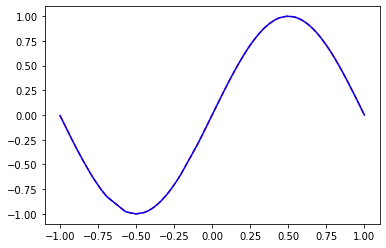

In [4]:
plt.plot(mesh.numpy(),u(mesh).numpy(),"r--")
plt.plot(mesh.numpy(),np.sin(np.pi*mesh.numpy()),"b-")

### Example - 1D Poisson (DNN1 $\sigma = \tanh$)

In [5]:
import tensorflow as tf
from tensorflow.keras.constraints import min_max_norm
import logging
tf.get_logger().setLevel(logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
from numsa.TFHessian import *
from random import *
from tqdm.notebook import tqdm


tf.random.set_seed(7)
############| SETTINGS |############
a = -1; b = 1;
N = 50; #Nuerons in the Hidden Layer
N_EvEl = 101; #Spacing of the evaluation function
itmax = 10000;
step = 1e-3;
tol=1e-32
gamma = tf.Variable(1e0,dtype=np.float32)
def f(x):
    return (np.pi**2)*np.sin(np.pi*x);
####################################

#Pnts = np.linspace(a,b,N_EvEl)


Pnts = np.array([0.0])
Pnts = np.append(Pnts,np.random.uniform(a,b,N_EvEl))
Pnts = np.append(Pnts,1.0)
#Pnts = np.random.uniform(a,b,N_EvEl)

Pnts = np.sort(Pnts)

u = tf.keras.Sequential([
    tf.keras.layers.Dense(N,input_dim=1, activation='tanh'),#Hidden Layer
    tf.keras.layers.Dense(N,activation="tanh"),
    tf.keras.layers.Dense(N,activation="tanh"),
    tf.keras.layers.Dense(1,use_bias=False)#10 leyers weights.
])

#We create an evaluation mesh
mesh = tf.Variable([[point] for point in Pnts]);
F = tf.cast(tf.Variable([[-f(point)] for point in Pnts]),dtype=np.float32);
#Defining the lost function
def LSQEnergy(weights):
    with tf.GradientTape() as gtape2:
        with tf.GradientTape() as gtape:
            uh = u(mesh, training=True)
        du_dx = gtape.gradient(uh, [mesh])
    #We use TF Gradient Tape to compute grad uh
    d2u_dx2 = gtape2.gradient(du_dx,[mesh])
    Delta = (d2u_dx2-F)
    Energy = (1/N_EvEl)*tf.reduce_sum(tf.square(Delta));
    #Adding B.C using penalty method idea;
    Energy = Energy + (gamma/N_EvEl)*(tf.square(u(tf.Variable([[a]])))+tf.square(u(tf.Variable([[b]]))))
    return Energy;
optimizer = tf.keras.optimizers.Adamax(learning_rate=step)

# Iterate over the batches of a dataset.
for it in tqdm(range(itmax)):
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        Loss = LSQEnergy(u.trainable_weights)
    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(Loss, u.trainable_weights)
    res = sum([tf.norm(grad) for grad in gradients]);
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, u.trainable_weights))
    if res <= tol:
        break;
    if it%(itmax/10) == 0:
        print("[It. {}] Loss function value {} and residual {}.".format(it,Loss,res))
    
print("Loss function value {} and residual {}.".format(Loss,res)) 

  0%|          | 0/10000 [00:00<?, ?it/s]

[It. 0] Loss function value [[47.177086]] and residual 31.57685661315918.
[It. 1000] Loss function value [[0.01183956]] and residual 0.16998037695884705.
[It. 2000] Loss function value [[0.00016934]] and residual 0.08250255137681961.
[It. 3000] Loss function value [[2.7573233e-05]] and residual 0.00855900626629591.
[It. 4000] Loss function value [[5.125262e-05]] and residual 0.5394493937492371.
[It. 5000] Loss function value [[2.0432639e-05]] and residual 0.04912548139691353.
[It. 6000] Loss function value [[1.8306335e-05]] and residual 0.029344793409109116.
[It. 7000] Loss function value [[1.686116e-05]] and residual 0.04942687973380089.
[It. 8000] Loss function value [[1.70672e-05]] and residual 0.13232438266277313.
[It. 9000] Loss function value [[1.40857865e-05]] and residual 0.015074023976922035.
Loss function value [[1.3298981e-05]] and residual 0.049428172409534454.


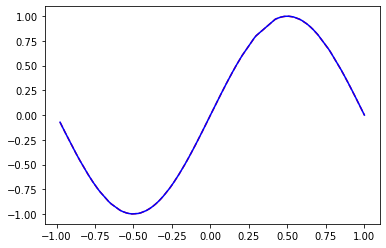

In [6]:
plt.plot(mesh.numpy(),u(mesh).numpy(),"r--")
plt.plot(mesh.numpy(),np.sin(np.pi*mesh.numpy()),"b-")